In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
import matplotlib.ticker
import matplotlib.cm as cm
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
%config InlineBackend.figure_format = 'svg'

# stabilities of Schamel $\sech^4$ electron hole

In [2]:
me = 1
Te = 1
mi = 100
Ti = 1

L = 60
vmax = 5 # 速度最大值
nx = 1000
nv = 1000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V,X=np.meshgrid(v,x)

dt = 0.02
max_steps = 1000
data_steps = max_steps
data_num = int(max_steps/data_steps)+1

path = 'E:/代码/vlasov-es1d/data/'
print(data_num)
print('real time = ', max_steps*dt)

2
real time =  20.0


## Schamel distribution
$$ f_e (v^2>2\phi) = \exp \left[ -\frac{\left(\pm\sqrt{v^2-2\phi}+u\right)^2}{2} \right] $$
$$ f_e (v^2<2\phi) = \exp \left[ -\beta \left(\frac{v^2}{2}-\phi\right) - \frac{u^2}{2} \right] $$
其中$v$为孤波参考系中的速度，静系速度$v_0=v+u$
- 此分布下的自洽孤波，用Newton-Raphson法解出

In [3]:
u = 0.0
beta = -2.0

r1 = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
b = np.exp(-u**2/2)*(1-beta-u**2)/np.sqrt(np.pi)

psi = (r1*15/16/b)**2
delta = 4.0/np.sqrt(r1)

print(delta)
print(psi)
# print(psi1)

4.0
0.3067961575771282


In [4]:
xp = (x-L/2)/delta
phi_sc = 2.5*psi*np.cosh(xp)**(-4)

In [5]:
@nb.jit
def nonvec_f_fun_sech4(v,phi):
    r = 0
    v_waveframe = v
    w = v_waveframe**2/2-phi
    if v_waveframe<=-abs(2*phi)**0.5:
        r=math.exp(-(-(2*w)**0.5+u)**2/2) 
    elif v_waveframe>abs(2*phi)**0.5:
        r=math.exp(-( (2*w)**0.5+u)**2/2) 
    else:
        r =math.exp(-beta*w-u**2/2) 
    return r/(2*np.pi)**0.5
f_fun_sech4 = np.vectorize(nonvec_f_fun_sech4)

In [7]:
for count in tqdm(range(10)):
    V,Phi=np.meshgrid(v,phi_sc)
    f_matrix = f_fun_sech4(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    
    # natural BC
#     laplace[0][0]=-1
#     laplace[-1][-1]=-1

    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi_sc[1:nx-1])
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi_sc[2:nx]-phi_sc[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi_sc[1:nx-1] += dphi
    
    err = ((dphi/phi_sc[1:nx-1])**2).sum()
    if err<= 1e-5:
        print("Sucess! Iteration counts =", count)
        break
print("err =", err)

 30%|████████████████████████▉                                                          | 3/10 [00:01<00:04,  1.54it/s]

Sucess! Iteration counts = 3
err = 1.382350048392225e-07


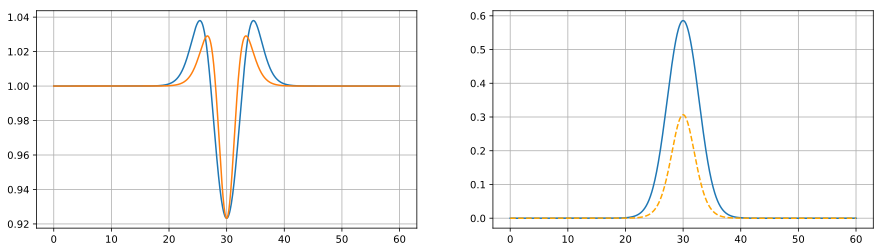

In [8]:
# psi = 0.0235
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_vector)
ax1.plot(x,1.0+psi/delta**2*(16*np.cosh(xp)**(-4)-20*np.cosh(xp)**(-6)))
ax1.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi_sc)
ax3.plot(x,psi*np.cosh((x-L/2)/delta)**(-4),color='orange',linestyle='--')
ax3.grid()
# ax3.set_xlim(0.3*L,0.7*L)
plt.show()

In [19]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path,"pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path,"kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

In [20]:
fig = plt.figure(figsize=(8, 2))

plt.plot(t, (dataet-dataet[0])/dataet[0]*100, color='black')
plt.ylabel(r'$(E_t-E_0)/E_0*100\%$')
plt.xlabel(r'$t$')
plt.show()

In [21]:
progesses = np.arange(0,data_num,1)

fe = []
phi = []
fi = []

for progess in tqdm(progesses):
    fe_temp = np.loadtxt(os.path.join(path,"fe"+str(progess)))
    fe.append(fe_temp)
    fi_temp = np.loadtxt(os.path.join(path,"fi"+str(progess)))
    fi.append(fi_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.02s/it]


In [22]:
fex0 = np.sum(fe[0],axis=1)*dv
fev0 = np.sum(fe[0],axis=0)*dx/L
fex = np.sum(fe[data_num-1],axis=1)*dv
fev = np.sum(fe[data_num-1],axis=0)*dx/L
fix0 = np.sum(fi[0],axis=1)*dv
fiv0 = np.sum(fi[0],axis=0)*dx/L
fix = np.sum(fi[data_num-1],axis=1)*dv
fiv = np.sum(fi[data_num-1],axis=0)*dx/L

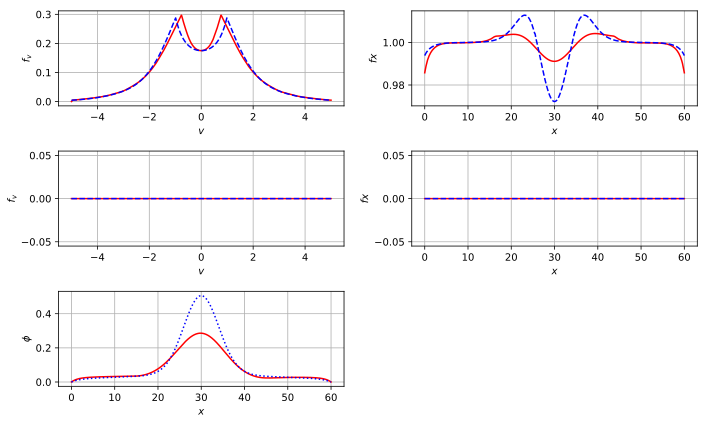

In [23]:
fig = plt.figure(figsize=(10, 6))
xzero = int(nx/2)

ax1 = plt.subplot(321)
ax1.plot(v, fe[data_num-1][xzero,:], color='red')
ax1.plot(v, fe[0][xzero,:],'--', color='blue')
ax1.set_xlabel(r'$v$')
ax1.set_ylabel(r'$f_{v}$')
# ax1.set_yscale('log')
ax1.grid()

ax2 = plt.subplot(322)
ax2.plot(x, fex, color='red')
ax2.plot(x, fex0,'--', color='blue')
ax2.set_xlabel(r'$v$')
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$fx$')
ax2.grid()

ax3 = plt.subplot(323)
ax3.plot(v, fi[data_num-1][xzero,:], color='red')
ax3.plot(v, fi[0][xzero,:],'--', color='blue')
# ax1.plot(v, fi[data_num-1][xzero,:],'--', color='blue')
ax3.set_xlabel(r'$v$')
ax3.set_ylabel(r'$f_{v}$')
# ax1.set_yscale('log')
ax3.grid()

ax4 = plt.subplot(324)
ax4.plot(x, fix, color='red')
ax4.plot(x, fix0,'--', color='blue')
ax4.set_xlabel(r'$v$')
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$fx$')
ax4.grid()

ax5 = plt.subplot(325)
ax5.plot(x, phi[1], color='red')
ax5.plot(x, phi[0],':', color='blue')
# ax5.plot(x, phi_sc,'--', color='black')
ax5.set_xlabel(r'$x$')
ax5.set_ylabel(r'$\phi$')
ax5.grid()

plt.tight_layout()
plt.show()

In [24]:
test_frame = data_num-1
Ze = fe[test_frame]
Ze[np.where(Ze<=0)]=0
Zi = fi[test_frame]
Zi[np.where(Zi<=0)]=0
lve_idx = np.linspace(-2,0,num=30)
lve = 10**lve_idx
lvi_idx = np.linspace(-40,1,num=20)
lvi = 10**lvi_idx
vle = 2.0
vli = 1.5

fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(221)
ax1cm = ax1.contourf(X, V, fe[0], levels=lve,norm=colors.LogNorm(vmin=lve.min(),vmax=lve.max()),cmap=cm.plasma)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$v$')
ax1.set_ylim(-vle,vle)

ax2 = plt.subplot(222)
ax2cm = ax2.contourf(X, V, Ze, levels=lve,norm=colors.LogNorm(vmin=lve.min(),vmax=lve.max()),cmap=cm.plasma)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$v$')
ax2.set_ylim(-vle,vle)

ax3 = plt.subplot(223)
ax3.contourf(X, V, fi[0], levels=lvi,norm=colors.LogNorm(vmin=lvi.min(),vmax=lvi.max()),cmap=cm.plasma)
ax3.set_xlabel(r'$x$')
ax3.set_ylabel(r'$v$')
ax3.set_ylim(-vli,vli)

ax4 = plt.subplot(224)
ax4.contourf(X, V, Zi, levels=lvi,norm=colors.LogNorm(vmin=lvi.min(),vmax=lvi.max()),cmap=cm.plasma)
ax4.set_xlabel(r'$x$')
ax4.set_ylabel(r'$v$')
ax4.set_ylim(-vli,vli)
plt.show()

c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\matplotlib\contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\matplotlib\contour.py:1562: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [38]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FFMpegFileWriter

c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
c:\users\rguo\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:2359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


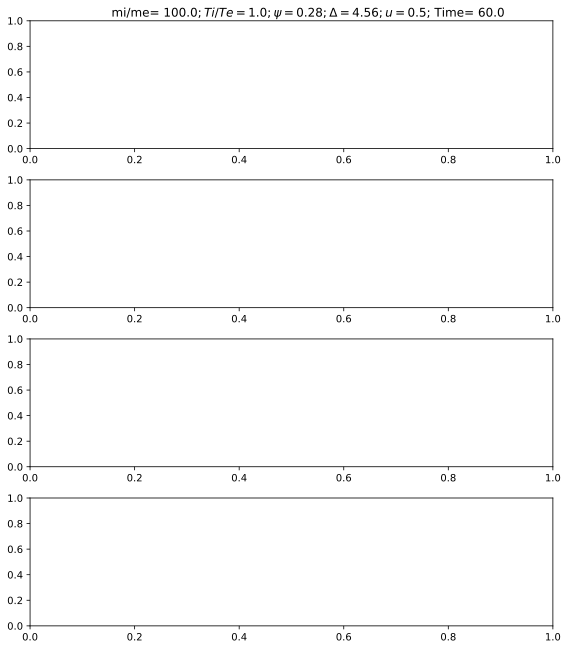

In [39]:
# xticks = np.linspace(0,L,num=7)
# fig = plt.figure(figsize=(8, 9))
# fig.set_tight_layout(True)
# writer = FFMpegFileWriter(fps=24,bitrate=-1,codec="libx264")
# with writer.saving(fig,"coupled_hole_soliton.mp4",dpi=300):
#     for frame in range(data_num):
#         ne = np.sum(fe[frame],axis=1)*dv
#         ni = np.sum(fi[frame],axis=1)*dv
        
#         ax1 = plt.subplot(411)
#         ax1.contourf(X, V, fe[frame], levels=lve,norm=colors.LogNorm(vmin=lve.min(),vmax=lve.max()),cmap=cm.plasma)
#         ax1.set_ylabel(r'$v$')
#         ax1.set_ylim(-vle,vle)
#         plt.xticks(xticks,[])

#         ax2 = plt.subplot(412)
#         ax2.contourf(X, V, fi[frame], levels=lvi,norm=colors.LogNorm(vmin=lvi.min(),vmax=lvi.max()),cmap=cm.plasma)
#         ax2.set_ylabel(r'$v$')
#         ax2.set_ylim(-vli,vli)
#         plt.xticks(xticks,[])

#         ax3 = plt.subplot(413)
#         ax3.plot(x, ne, color='red',label=r'$n_e$')
#         ax3.plot(x, ni, color='blue',label=r'$n_i$')
#         ax3.set_ylabel(r'$n$')
#         ax3.set_xlim(0,60)
#         ax3.set_ylim(0.9,1.15)
#         plt.xticks(xticks,[])
#         ax3.legend()
#         ax3.grid()

#         ax4 = plt.subplot(414)
#         ax4.plot(x, phi[frame], color='blue')
#         ax4.set_xlabel(r'$x$')
#         ax4.set_ylabel(r'$\phi$')
#         ax4.set_xlim(0,60)
#         ax4.set_ylim(-0.1,0.62)
#         plt.xticks(xticks)
#         ax4.grid()

#         title_text = "mi/me= " + str(round(mi/me,2)) + r"$; Ti/Te= $" + str(Ti/Te) + r"$; \psi= $" + str(round(psi,2)) + r"$; \Delta= $" + str(round(delta,2)) + r"$; u= $" + str(round(u,2)) + "; Time= " + str(round(dt*frame*data_steps,1))
#         fig.suptitle(title_text,x=0.2, va='bottom',ha='left')
#         writer.grab_frame()
#         ax1.cla()
#         ax2.cla()
#         ax3.cla()
#         ax4.cla()